# Pricing American options in rough Bergomi with linear and deep signatures

In this notebook we show how to use the code from https://github.com/lucapelizzari/Optimal_Stopping_with_signatures/tree/main, to compute lower and upper bounds for American options in the rough Bergomi model using different signature methods, see for example Section 4.2 of https://arxiv.org/abs/2312.03444 for the linear approach, whereas the deep neural network approaches will be discussed in a forthcoming paper.

The repository consists of:

*   Simulation packages for fractional Brownian motion, rough Bergomi and rough Heston models
*   A modul for signature related computations **Signature_computer.py**, which can compute the signature and log-signature  of various lifts related to volatility modelling, with the additional option of adding polynomials of the state-process and/or volatility.
*   The main module for the linear signature approaches **Linear_signature_optimal_stopping.py**, which can be used to derive lower and upper bounds to the optimal stopping problem applying the approaches described in https://arxiv.org/abs/2312.03444
*   The main module for deep log-signature approaches **Deep_signature_optimal_stopping.py**, which extends the linear approaches by applying deep neural networks on the log-signature. This code is accompanying a working paper paper on "American option pricing using signatures"






## American Put options in the rough Bergomi model



Recall the price and volatility dynamics of the latter are given by \begin{align*}
dX_t &= rX_tdt+X_tv_t \left (\rho dW_r+\sqrt{1-\rho^2}dB_t\right ), \\ v_t & =\xi_0\mathcal{E}\left (\eta \int_0^t(t-s)^{H-\frac{1}{2}}dW_s \right )
\end{align*} and pricing an American Put-option can be formulated as optimal stopping problem $$y_0=\sup_{\tau \in \mathcal{S}_0}\mathbb{E}[e^{-r\tau}\left (K-X_{\tau}\right )^{+}]$$ for some strike $K$. In this notebook we consider the following choice of paramteres $$ H=0.07,X_0 = 100, r=0.05, \eta = 1.9, \rho = -0.9, \xi_0= 0.09, K = 110.$$


## Step 1: Simulation rough Bergomi model

We start by defining the parameters of the model and importing the rough Berogmi simulation package.

In [4]:

N1 = 12 #number of exercise-dates
N = 120 #discretization-grid for computing the siganture (that is iterated integrals)
T = 1 #Maturity
M = 2**15 #number of samples for training
M2 = 2**15 #number of samples for testing


Note that the number of samples should be much bigger to get reliable results, but to keep the complexity low in this presentation we restrict to $2**15$ training and testing paths here.

In [5]:

import numpy as np
h = 0.1
eta = 1.9
X0 = 1
r = 0.05
rho = -0.9
xi = 0.09
strike = 1.05
def phi(x):
    return np.maximum(strike-x,0) #payoff function


In [6]:
from rBergomi_simulation import SimulationofrBergomi

Next we define a function generating rough Bergomi prices, volatilies and the corresponding Brownian motion and payoff process. Then we generate training and testing data.

In [7]:
def generate_data(M, N, T, phi, rho, K, X0, H, xi, eta, r):
    X, V, I, dI, dW1, dW2, dB, Y = SimulationofrBergomi(M, N, T, phi, rho, K, X0, H, xi, eta, r)

    # Calculate Payoff
    Payoff = phi(X)

    return X, V, Payoff, dB


In [8]:
S_training, V_training, Payoff_training, dW_training = generate_data(M, N, T, phi, rho, strike, X0, h, xi, eta, r)
S_testing, V_testing, Payoff_testing, dW_testing = generate_data(M2, N, T, phi, rho, strike, X0, h, xi, eta, r)

In [9]:
#compute the volatility processes
vol_training = np.sqrt(V_training)
vol_testing = np.sqrt(V_testing)

## Step 2: Signature computations

We will make us uf the iisignature package https://pypi.org/project/iisignature/ to compute the signature, and it can be installed using pip:

In [1]:
!pip install iisignature #will be used for signature computations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for iisignature: filename=iisignature-0.24-cp310-cp310-linux_x86_64.whl size=3245486 sha256=1d6f4a9f246873ef933ac6c1fbb6fdacc18b692142c8d8e42f24100273870bab
  Stored in directory: /root/.cache/pip/wheels/c8/13/d1/42e1aa7f8a8e1189360df53c461f0e13f43e0d2170ef16d349
Successfully built iisignature


We import our signature computation module, which can compute various signature and log signature lift related to the generated data

In [10]:
from Signature_computer import SignatureComputer

Next we initialize the **SignatureComputer**, which allows to choose from the linear and the log signature, and various choices of signature lifts. Here are some examples $$ t\mapsto \mathrm{Sig}(A_t,X_t),t\mapsto \mathrm{Sig}(A_t,\phi(X)_t),t\mapsto \mathrm{Sig}(A_t,X_t,X_{t-\epsilon}),t\mapsto \mathrm{Sig}(A_t,X_t,\phi(X_t)),t\mapsto \mathrm{Sig}(A_t,v_t),$$ where $t\mapsto A_t$ is a monoton path and in our examples we choose between $$A_t=t, \quad  A_t = \langle X\rangle_t.$$ Additonally we can add Laguerre polynomials of $X$ or $(X,v)$ to the signature, see the module for all the details.

In this example we choose the basis $(\mathrm{Sig}(t,v_t),p_i(X_t))$, which proves to be a solid choice for rough volatility models. We choose both the polynomial and signature degree to be $3$ for this example. (To improve result one should higher truncations levels ($4-5$) for the signature, but to keep the complexity reasonable here we choose level $3$ signatures.)

In [11]:
#initialize signature computer
sig_computer = SignatureComputer(T, N, 3, "linear", signature_lift="polynomial-vol", poly_degree=3)

In [12]:
#Compute the signature for training and test data
tt = np.linspace(0,T,N+1)
A_training = np.zeros((M, N+1)) #time-augmentation
A_testing = np.zeros((M2, N+1))
A_training[:, 1:] = A_testing[:, 1:] = tt[1:]
signatures_training = sig_computer.compute_signature(S_training, vol_training, A_training, Payoff_training)
signatures_testing = sig_computer.compute_signature(S_testing, vol_testing, A_testing, Payoff_testing)

Computing linear signature with polynomial-vol lift
Computing linear signature with polynomial-vol lift


Some example of the signature paths

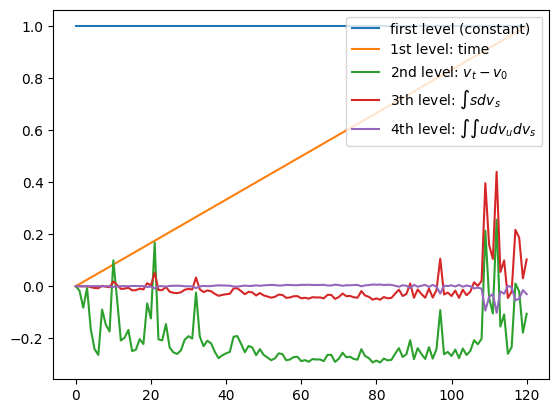

In [18]:
import matplotlib.pyplot as plt
plt.plot(signatures_training[0,:,0],label = 'first level (constant)')
plt.plot(signatures_training[0,:,1],label = '1st level: time ')
plt.plot(signatures_training[0,:,2],label = '2nd level: $v_t-v_0$')
plt.plot(signatures_training[0,:,4],label = '3th level: $\int sdv_s $')
plt.plot(signatures_training[0,:,12],label = '4th level: $\int \int udv_u dv_s $')
plt.legend(loc='upper right')


## Step 3: Compute pricing intervals with linear signatures


We can now import the linear primal and dual pricers, which compute true lower and upper bounds.
- The **LinearLongstaffSchwartzPricer** uses the signature of the training data to recursively approximate continuation values in the spirit of the Longstaff-Schwartz algorithm (descibed in detail in Section 3.1 of https://arxiv.org/abs/2312.03444). The resulting regression coefficients at each exercise date provide a stopping rule, which can be applied to the testing data to get true lower-bounds
- The **LinearDualPricer** uses the signature of the training data to minimize over the familiy of linear signature martingales, by solving a corresponding linear program (described in Detail in Section 3.2 of https://arxiv.org/abs/2312.03444). The resulting coefficients yield a Doob martingale approximation, which for the testing data yields a true upper bound.
By combining the two values, we receive confidence intervals for the true option price.

To solve the linear programm, one can optionally choose to use Gurobi https://www.gurobi.com, which requires a free licence, which is recommended especially for high-dimensional LPs, which occur when choosing large sample-sizes and/or high signature truncations levels. Alternatively, we use the free LP solvers from CVXPY

In [29]:
!pip install gurobipy
import cvxpy as cp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 65.9 MB/s eta 0:00:00


In [19]:
from Linear_signature_optimal_stopping import LinearLongstaffSchwartzPricer, LinearDualPricer

In [20]:
#initialze the models
ls_pricer = LinearLongstaffSchwartzPricer(
        N1=N1,
        T=T,
        r=r,
        mode="American Option",
        ridge=10**(-9)
    )

dual_pricer = LinearDualPricer(
        N1=N1,
        N=N,
        T=T,
        r=r,
        LP_solver="CVXPY"
    )

The choice mode="American Option" indicates that the Longstaff-Schwartz recursion will only consider "in-the-money" paths, which was originally suggested by Longstaff & Schwartz, and is reasonable for non-negative payoffs. For general payoffs we can use mode = "Standard".

In [21]:
#compute true lower bounds
lower_bound, lower_bound_std, ls_regression_models = ls_pricer.price(
        signatures_training,
        Payoff_training,
        signatures_testing,
        Payoff_testing
    )

Regression score at exercise date 11 0.879074893573295
Regression score at exercise date 10 0.8283026954851904
Regression score at exercise date 9 0.7715563694750199
Regression score at exercise date 8 0.713261644642452
Regression score at exercise date 7 0.6706796953262832
Regression score at exercise date 6 0.6049425168920779
Regression score at exercise date 5 0.5364418271652729
Regression score at exercise date 4 0.46574609400370215
Regression score at exercise date 3 0.37015867641519873
Regression score at exercise date 2 0.2679615005535688
Regression score at exercise date 1 0.13527886696061642


In [22]:
print(f"Linear Longstaff-Schwartz lower bound: {lower_bound} ± {lower_bound_std/np.sqrt(M2)}")

Linear Longstaff-Schwartz lower bound: 0.10375378103434676 ± 0.000791163603521302


Similarly let us derive the upper bounds, but we will train the model only for $M= 5000$ paths to reduce computation time, and then compute true prices for all testing samples.

In [23]:
M_dual = 5000
upper_bound, upper_bound_std, MG = dual_pricer.price(
        signatures_training[:M_dual,:,:],
        Payoff_training[:M_dual,:],
        dW_training[:M_dual,:],
        signatures_testing,
        Payoff_testing,
        dW_testing
    )


19.28 seconds needed to solve the linear program using CVXPY


In [24]:
print(f"Linear Dual upper bound: {upper_bound} ± {upper_bound_std/np.sqrt(M2)}")
print(f"Pricing interval: {(lower_bound,upper_bound)}± {np.maximum(upper_bound_std,lower_bound_std)/np.sqrt(M2)} ")


Linear Dual upper bound: 0.11833350063234141 ± 0.00023638233060000103
Pricing interval: (0.10375378103434676, 0.11833350063234141)± 0.000791163603521302 


# Improving the duality gap


Especially in rough regimes (here $H=0.1$), we observe a significant gap between lower and upper bounds, and in this section we present two ways to improve it. The first one still relies on linear signatures, but extends the basis as explained in in Section 4 of https://arxiv.org/abs/2312.03444.

## Part 1: Extending the linear basis

We consider a more involved basis by choosing the extended signature lift of $(t,X_t,\phi(X_t))$, and additionally add Laguerre polynomials of $(X_t,v_t)$. We can again use the SignatureComputer to compute this extended basis:

In [25]:
sig_computer_extended = SignatureComputer(T, N, 3, "linear", signature_lift="payoff-and-polynomial-extended", poly_degree=3)

In [26]:
signatures_extended_training = sig_computer_extended.compute_signature(S_training, vol_training, A_training, Payoff_training)
signatures_extended_testing = sig_computer_extended.compute_signature(S_testing, vol_testing, A_testing, Payoff_testing)

Computing linear signature with payoff-and-polynomial-extended lift
Computing linear signature with payoff-and-polynomial-extended lift


Now we repeat the procedure for the extended basis:

In [27]:

#compute true lower bounds for the new basis
lower_bound_extended, lower_bound_extended_std, ls_regression_models_extended = ls_pricer.price(
        signatures_extended_training,
        Payoff_training,
        signatures_extended_testing,
        Payoff_testing
    )
#Repeating the dual procedure for the new basis
upper_bound_extended, upper_bound_extended_std, MG_extended = dual_pricer.price(
        signatures_extended_training[:M_dual,:,:],
        Payoff_training[:M_dual,:],
        dW_training[:M_dual,:],
        signatures_extended_testing,
        Payoff_testing,
        dW_testing
    )

Regression score at exercise date 11 0.8798087633519537
Regression score at exercise date 10 0.8418327496395068
Regression score at exercise date 9 0.795302562456482
Regression score at exercise date 8 0.7513424374820942
Regression score at exercise date 7 0.715258690459537
Regression score at exercise date 6 0.6532488651452969
Regression score at exercise date 5 0.5847794962247419
Regression score at exercise date 4 0.520594396405428
Regression score at exercise date 3 0.41169930961417833
Regression score at exercise date 2 0.29669813340965545
Regression score at exercise date 1 0.14880405110557882
79.61 seconds needed to solve the linear program using CVXPY


In [29]:
print(f"Improve pricing interval: {(lower_bound_extended,upper_bound_extended)}± {np.maximum(upper_bound_std,lower_bound_std)/np.sqrt(M2)} ")

Improve pricing interval: (0.10343445820044898, 0.11084565793548704)± 0.000791163603521302 


## Part 2: Deep log-signature optimal stopping

 In forthcoming work about "American options in rough volatility models", we will focus on more non-linear apporaches to price American options. More precisely, we extend the primal and dual procecdure by replacing linear functionals of the signature by deep neural networks on the log-signature $\mathbb{L}=\mathrm{log}^\otimes(\mathbb{X})$. This transformed version of the signature still captures the relevant information about the past of the underlying process, but grows much slower as the signature it self with respect to the truncation. Then, in order to learn highly non-linear functionals, such as the integrand of the Doob martingale ("derivative of the Snell-envelope"), we apply deep feedforward neural networks $\theta$ on the log-signature. Of course, in both methods a optimization of the hyperparameters is required.

We proceed as before, but replace the linear signature by the log-signature

In [30]:
sig_computer_log = SignatureComputer(T, N, 3, "log", signature_lift="polynomial-vol", poly_degree=3)

In [36]:
log_signatures_training = sig_computer_log.compute_signature(S_training, vol_training, A_training, Payoff_training)
log_signatures_testing = sig_computer_log.compute_signature(S_testing, vol_testing, A_testing, Payoff_testing)

Computing log signature with polynomial-vol lift
Computing log signature with polynomial-vol lift


In [33]:
from Deep_signatures_optimal_stopping import DeepLongstaffSchwartzPricer, DeepDualPricer

The DeepLongstaffSchwartzPricer generalizes the LinearLongstaffSchwartzPrices, where the Ridge Regression at each exercise date is replace by learning the conditional expectations via neural networks. In the following initialization we build a network with $3$ hidden layers and $16$ neurons each, between each hidden layer we apply the activation function $\mathrm{tanh}(x)$. The remainding parameters are set to 'False'. (One can run the 'Hyperparameter_optimization_primal.py' file to optimize the choice of hyperparameters)

In [34]:
ls_pricer = DeepLongstaffSchwartzPricer(
        N1=N1,
        T=T,
        r=r,
        mode="American Option",
        layers=3,
        nodes=16,
        activation_function='tanh',
        batch_normalization=False,
        regularizer=False,
        dropout=False,
        layer_normalization=False
    )

Similarly for the dual problem, we consider the same network but use the $relu(x)$ activation instead.

In [35]:
dual_pricer = DeepDualPricer(
        N1=N1,
        N=N,
        T=T,
        r=r,
        layers=3,
        nodes=16,
        activation_function='relu',
        batch_normalization=False,
        regularizer=False,
        dropout=False,
        attention_layer=False,
        layer_normalization=False
    )

The Deep Longstaff Schwartz uses $15$ epochs for at the last exercise date, and then one epochs at the remainding ones by initiliazing smartly. The learning rate for the Stochastic Gradient Descent is choosen as $0.001$, and we use batch sizes of $2^8$.

In [37]:

lower_bound_deep, lower_bound_deep_std, ls_regression_models = ls_pricer.price(
        log_signatures_training,
        Payoff_training,
        signatures_testing,
        Payoff_testing,
        M_val=0,
        batch=2**8,
        epochs=15,
        learning_rate=0.001
    )

Regression at exercise date 11
Epoch 1/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0582 - r2_score: -0.2748
Epoch 2/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067 - r2_score: 0.8461
Epoch 3/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064 - r2_score: 0.8541
Epoch 4/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060 - r2_score: 0.8619
Epoch 5/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 - r2_score: 0.8703
Epoch 6/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0056 - r2_score: 0.8724
Epoch 7/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0056 - r2_score: 0.8754
Epoch 8/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054 - r2_score: 0.8774
Epoch 9/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0053 - r2_score: 0.8820
Epoch 10/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054 - r2_score: 0.8772
Epoch 11/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0054 - r2_score: 0.8763
Epoch 12/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
print(f"Deep Longstaff-Schwartz lower bound: {lower_bound_deep} ± {lower_bound_deep_std/np.sqrt(M2)}")

The pricing interval is given by [array([13.18448087]), array([13.76010404])]


In [38]:
y0, upper_bound_deep, upper_bound_deep_std, dual_model, dual_rule_model = dual_pricer.price(
        log_signatures_training,
        Payoff_training,
        dW_training,
        log_signatures_testing,
        Payoff_testing,
        dW_testing,
        M_val=int(0.9*M),
        batch=2**8,
        epochs=15,
        learning_rate=0.01
    )

Epoch 1/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - loss: 0.1287 - val_loss: 0.1113
Epoch 2/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.1102 - val_loss: 0.1091
Epoch 3/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - loss: 0.1091 - val_loss: 0.1114
Epoch 4/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 0.1088 - val_loss: 0.1092
Epoch 5/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 0.1090 - val_loss: 0.1091
Epoch 6/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - loss: 0.1084 - val_loss: 0.1092
Epoch 7/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 0.1085 - val_loss: 0.1091
Epoch 8/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.1085 - val_loss: 0.1091
Epoch 9/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.1088 - val_loss: 0.1086
Epoch 10/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.1088 - val_loss: 0.1086
Epoch 11/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.1089 - val_loss: 0.1095
Epoch 12/15
116/116 ━━━━━━━━━━━━━━━━━

In [39]:
print(f"Deep Dual upper bound: {upper_bound_deep} ± {upper_bound_deep_std/np.sqrt(M2)}")
print(f"Pricing interval: {(lower_bound_deep,upper_bound_deep)}± {np.maximum(upper_bound_deep_std,lower_bound_deep_std)/np.sqrt(M2)} ")

Deep Dual upper bound: 0.10946182914871373 ± 0.00018673168737941867
Pricing interval: (0.1023930573468258, 0.10946182914871373)± 0.0007367138813281993 


We once again stress that the parameters for the the discretization (here $J=120$), the sample size (here $M=10^{15}$), and the signature trunaction level (here $K=3$) are not choosen big enough to get narrow gaps, but we can still already observe an improvement.